Our task is simple: unify and standardize ISO data sets into 1 dataframe
Here are the things we need to make sure we are doing:
- converting any timestamps or time associated data columns to datetime
- making sure that we are labeling where each sub data set comes from (e.g. ERCOT, SPP, etc.)
- making sure that we are able to apply transformations to datasets in 2 phases
    - phase 1: transformations on each ISO before merging to main df 
    - phase 2: transformations on the main df

In [8]:
# importing iso specific functions files so that we can apply transformations
from private_info import ercot_functions as efuncs

In [2]:
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import date, datetime, timedelta

In [3]:
# allows us to define a date and from that assemble correct path refs
## today = date.today()  <-- only use this if you just pulled data today

# defining our date
today = "2025-05-14"  # should always be in the YYYY-MM-DD format

year_str = str(today)[:4]
month_str = str(today)[5:7]
day_str = str(today)[-2:]


print(today)
print(f'year string: {year_str}')
print(f'month string: {month_str}')
print(f'day string: {day_str}')

2025-05-14
year string: 2025
month string: 05
day string: 14


In [18]:
# loading in data that we have pulled
ercot_data = pl.read_csv(f'datasets/ercot_lmp_data/lmp_node_zone_hub_csv/{today}_lmp_node_zone_hub.csv')
spp_data = pl.read_csv(f'datasets/spp_lmp_data/LMP_By_SETTLEMENT_LOC/LMP_By_SETTLEMENT_LOC_{year_str}{month_str}{day_str}.csv')
nyiso_data = pl.read_csv(f'datasets/nyiso_lmp_data/realtime_zone/{year_str}{month_str}{day_str}.csv')

In [16]:
# transforming our data sets before the main merge so that we can view it
ercot_df = efuncs.transform_ercot_data(ercot_df=ercot_data)
ercot_df.describe()

statistic,timestamp,repeatHourFlag,node_id,5min_lmp,iso_id,hour
str,str,f64,str,f64,str,f64
"""count""","""500000""",500000.0,"""500000""",500000.0,"""500000""",500000.0
"""null_count""","""0""",0.0,"""0""",0.0,"""0""",0.0
"""mean""","""2025-05-14 23:24:16.493040""",0.0,null,29.880495,null,11.346966
"""std""",null,null,null,36.20153,null,6.13508
"""min""","""2025-05-14 03:05:00""",0.0,"""7RNCHSLR_ALL""",-630.0,"""ERCOT""",0.0
"""25%""","""2025-05-14 13:30:00""",null,null,15.76,null,6.0
"""50%""","""2025-05-14 23:15:00""",null,null,22.57,null,11.0
"""75%""","""2025-05-15 09:30:00""",null,null,38.57,null,16.0
"""max""","""2025-05-15 19:15:00""",0.0,"""ZIER_SLR_ALL""",2874.48,"""ERCOT""",23.0


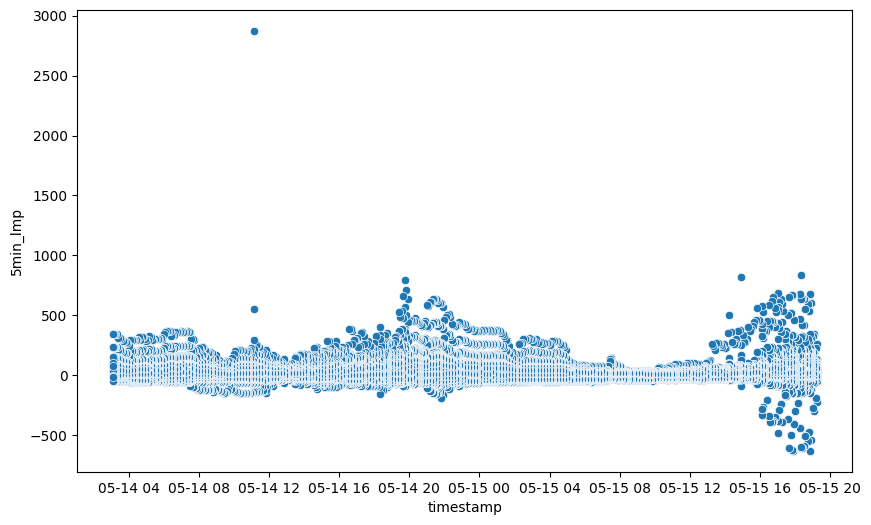

In [ ]:
plt.figure(figsize=[10,6])

sns.scatterplot(data=ercot_df, x='timestamp', y='5min_lmp')

plt.show()